34 31
51 49
CGLS Algorithm in progress.
Estimated time until completion : 00:00:00
re-initilization of CGLS called at iteration:1
Algorithm exited with two consecutive reinitializations.
SART algorithm in progress.
Estimated time until completion : 00:00:07
SIRT algorithm in progress.
Estimated time until completion : 00:00:00


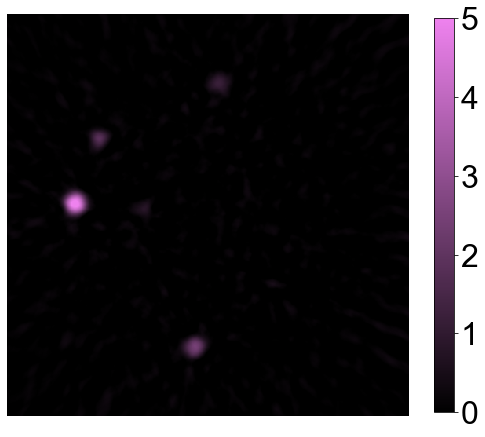

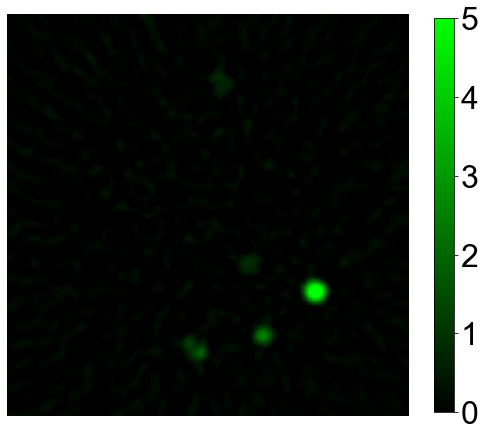

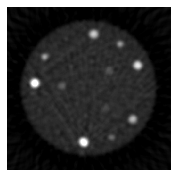

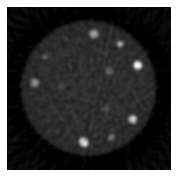

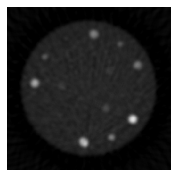

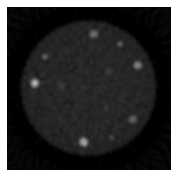

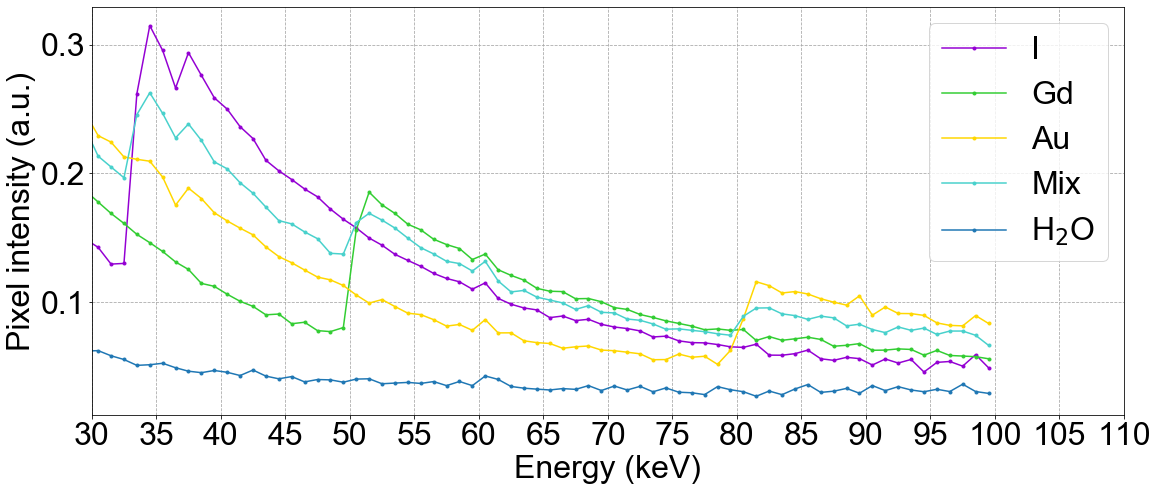

In [8]:
import tigre
import numpy as np
import tigre.algorithms as algs
from matplotlib import pyplot as plt
from numpy import genfromtxt
from matplotlib.pyplot import figure
from skimage.transform import iradon
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
import scipy as sp

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 32}

matplotlib.rc('font', **font)

bin_width=1
bins=np.arange(20,100,bin_width)
master_counts=np.load("Desktop/CT imaging/master_counts_strip_8deg.npy")
master_counts=np.squeeze(master_counts)
master_binned=np.zeros((45,96,int(np.ceil(len(bins)))))
for k in np.arange(0,len(bins)):
    for i in np.arange(0,45):
        for j in np.arange(0,96):
            master_binned[i][j][k]=master_counts[i][j][int(np.around((bins[0]+bin_width*k)/0.2)):int(np.around((((bins[0]+bin_width*(k+1))/0.2))))].mean()
master_binned=np.transpose(master_binned)
master_counts=master_binned
master_counts=np.swapaxes(master_counts,1,2)
for i in np.arange(0,len(master_counts)):
    master_counts[i][4]=np.insert(master_counts[i][4][:-1],0,0)
    master_counts[i][38]=np.insert(master_counts[i][38][:-1],0,0)
master_counts=np.swapaxes(master_counts,1,2)

print(bins[14],bins[11])
print(bins[31],bins[29])
subtraction=master_counts[14]-master_counts[11]
subtraction = np.copy((subtraction.T)[:,np.newaxis,:]).astype(np.float32)
subtraction2=master_counts[31]-master_counts[29]
subtraction2 = np.copy((subtraction2.T)[:,np.newaxis,:]).astype(np.float32)
#Geometry--------------------------------------------------------------------------
geo = tigre.geometry()
# VARIABLE                                   DESCRIPTION                    UNITS
# -------------------------------------------------------------------------------------
# Distances
geo.DSD = 1086 # Distance Source Detector      (mm)
geo.DSO = 626 # Distance Source Origin        (mm)
# Image parameters
geo.nVoxel = np.array([1, 512, 512])  # number of voxels              (vx)
geo.sVoxel = np.array([1, 120, 120])  # total size of the image       (mm)
geo.dVoxel = geo.sVoxel / geo.nVoxel  # size of each voxel            (mm)
# Detector parameters
geo.nDetector = np.array([1, 96])  # number of pixels              (px)
geo.dDetector = np.array([geo.dVoxel[0], 1.25])  # size of each pixel            (mm)
geo.sDetector = geo.nDetector * geo.dDetector  # total size of the detector    (mm)
# Offsets
geo.offOrigin = np.array([0, 0, 0])  # Offset of image from origin   (mm)
geo.offDetector = np.array([0, 0])  # Offset of Detector            (mm)
# MAKE SURE THAT THE DETECTOR PIXELS SIZE IN V IS THE SAME AS THE IMAGE!

# Offsets
geo.offOrigin = np.array([0, 0, 0])  # Offset of image from origin   (mm)
geo.offDetector = np.array([0, 0])  # Offset of Detector            (mm)

geo.mode = "parallel"

angles = np.arange(0,2*np.pi,(2*np.pi)/45)
theta=angles


#Colormaps
cmap = LinearSegmentedColormap.from_list(name='lime',colors=['black','lime'])
plt.register_cmap('lime', cmap)
cmap = LinearSegmentedColormap.from_list(name='violet',colors=['black','violet'])
plt.register_cmap('violet', cmap)

#Algorithms------------------------------------------------------------------------
niter=20

#FDK
imgFDKI = algs.fdk(subtraction, geo, angles, filter='hann')
imgFDKI=np.squeeze(imgFDKI)
imgFDKI[imgFDKI<0] = 0
imgFDKGd = algs.fdk(subtraction2, geo, angles, filter='hann')
imgFDKGd=np.squeeze(imgFDKGd)
imgFDKGd[imgFDKGd<0] = 0
# CGLS
imgCGLS = algs.cgls(subtraction, geo, angles, niter)
imgCGLS=np.squeeze(imgCGLS)
imgCGLS[imgCGLS<0] = 0
# SART
imgSART = algs.sart(subtraction, geo, angles, niter)
imgSART=np.squeeze(imgSART)
imgSART[imgSART<0] = 0

#SIRT
imgSIRT= algs.sirt(subtraction,geo,angles,niter)
imgSIRT=np.squeeze(imgSIRT)
imgSIRT[imgSIRT<0] = 0

# # FISTA
# imgFISTA = algs.fista(subtraction, geo, angles, niter)
# imgFISTA=np.squeeze(imgFISTA)
# imgFISTA[imgFISTA<0] = 0

# # ASDPOCS
# imgASDPOCS = algs.asd_pocs(subtraction, geo, angles, niter)
# imgASDPOCS=np.squeeze(imgASDPOCS)
# imgASDPOCS[imgASDPOCS<0] = 0

# # AWASDPOCS
# imgAWASDPOCS = algs.awasd_pocs(subtraction, geo, angles, niter)
# imgAWASDPOCS=np.squeeze(imgAWASDPOCS)
# imgAWASDPOCS[imgAWASDPOCS<0] = 0


imgFDKGd=imgFDKGd.T
imgFDKI=imgFDKI.T

#Normalize-----------------------------------------
imgFDKGd=imgFDKGd*5/0.11376619890332222*5/4.61939439535141
imgFDKI=imgFDKI*5/0.15945564448833466*5/5.80269935131073

#Display -------------------------------------------------------------------------------------------
figure(1,figsize=(9,10))
plt.imshow(imgFDKI,cmap='violet',vmax=5)
plt.colorbar(shrink=0.725)
plt.axis('off')

figure(2,figsize=(9,10))
plt.imshow(imgFDKGd,cmap='lime',vmax=5)
plt.colorbar(shrink=0.725)
plt.axis('off')
# figure(2,figsize=(9,8))
# plt.imshow(imgCGLS,cmap='lime')
# plt.colorbar()
# plt.title('CGLS Image')

# figure(3,figsize=(9,8))
# plt.imshow(imgSART,cmap='lime')
# plt.colorbar()
# plt.title('SART Image')
# figure(4,figsize=(9,8))
# plt.imshow(imgSIRT,cmap='lime')
# plt.colorbar()
# plt.title('SIRT Image')

# figure(5,figsize=(9,8))
# plt.imshow(imgFISTA,cmap='lime')
# plt.colorbar()
# plt.title('FISTA Image')

# figure(6,figsize=(9,8))
# plt.imshow(imgASDPOCS,cmap='lime')
# plt.colorbar()
# plt.title('ASD_POCS Image')

# figure(7,figsize=(9,8))
# plt.imshow(imgAWASDPOCS,cmap='lime')
# plt.colorbar()
# plt.title('AWASD_POCS Image')

#Vial coordinates 512x512
coordsI5 =[[i+82,j+238] for i in np.arange(0,10) for j in np.arange(0,10)] 
coordsI3 =[[i+116,j+156] for i in np.arange(0,5) for j in np.arange(0,5)]
coordsI1=[[i+174,j+248] for i in np.arange(0,5) for j in np.arange(0,5)]
coordsGd5=[[i+392,j+353] for i in np.arange(0,10) for j in np.arange(0,10)] 
coordsGd3=[[i+327,j+412] for i in np.arange(0,5) for j in np.arange(0,5)]
coordsGd1=[[i+313,j+321] for i in np.arange(0,5) for j in np.arange(0,5)]
coordsAu5=[[i+406,j+183] for i in np.arange(0,10) for j in np.arange(0,10)] 
coordsAu3=[[i+352,j+116] for i in np.arange(0,5) for j in np.arange(0,5)]
coordsAu1=[[i+319,j+203] for i in np.arange(0,5) for j in np.arange(0,5)]
coordsMix33=[[i+239,j+426] for i in np.arange(0,10) for j in np.arange(0,10)]
coordsMix2=[[i+268,j+88] for i in np.arange(0,10) for j in np.arange(0,10)]
coords0=[[i+185,j+101] for i in np.arange(0,5) for j in np.arange(0,5)]
coords01=[[i+360,j+240] for i in np.arange(0,40) for j in np.arange(0,40)]
coords02=[[i+240,j+240] for i in np.arange(0,40) for j in np.arange(0,40)]
coords03=[[i+140,j+330] for i in np.arange(0,20) for j in np.arange(0,20)]


# Pixel intensity vs energy for each vial
images=[]
for i in np.arange(0,len(bins)):
    img=algs.fdk(np.copy((np.array(master_counts[i]).T)[:,np.newaxis,:]).astype(np.float32), geo, angles, filter='hann')
    img=img.T
    img[img<0]=0
    images.append(img)
images=np.squeeze(images)

figure(9,figsize=(3,3))
plt.imshow(images[14],cmap='gray',vmin=0,vmax=0.25)
plt.axis('off')


figure(10,figsize=(3,3))
plt.imshow(images[11],cmap='gray',vmin=0,vmax=0.25)
plt.axis('off')

figure(11,figsize=(3,3))
plt.imshow(images[31],cmap='gray',vmin=0,vmax=0.25)
plt.axis('off')

figure(12,figsize=(3,3))
plt.imshow(images[29],cmap='gray',vmin=0,vmax=0.25)
plt.axis('off')

mask=np.zeros(shape=(512,512))
for x,y in coordsI5:
    mask[int(y)][int(x)]=1
vial1=mask*images
vial1[vial1==0]=np.nan
vial1_mean=[np.nanmean(i) for i in vial1]

mask=np.zeros(shape=(512,512))
for x,y in coordsGd5:
    mask[int(y)][int(x)]=1
vial2=mask*images
vial2[vial2==0]=np.nan
vial2_mean=[np.nanmean(i) for i in vial2]

mask=np.zeros(shape=(512,512))
for x,y in coordsAu5:
    mask[int(y)][int(x)]=1
vial3=mask*images
vial3[vial3==0]=np.nan
vial3_mean=[np.nanmean(i) for i in vial3]

mask=np.zeros(shape=(512,512))
for x,y in coordsMix33:
    mask[int(y)][int(x)]=1
vial4=mask*images
vial4[vial4==0]=np.nan
vial4_mean=[np.nanmean(i) for i in vial4]

mask=np.zeros(shape=(512,512))
for x,y in coords0:
    mask[int(y)][int(x)]=1
vial5=mask*images
vial5[vial5==0]=np.nan
vial5_mean=[np.nanmean(i) for i in vial5]

#intensity of vials vs energy
figure(8,figsize=(18.5,7.5))
plt.plot(bins+bin_width/2,vial1_mean,marker='.',label='I',c='darkviolet')
plt.plot(bins+bin_width/2,vial2_mean,marker='.',label='Gd',c='limegreen')
plt.plot(bins+bin_width/2,vial3_mean,marker='.',label='Au',c='gold')
plt.plot(bins+bin_width/2,vial4_mean,marker='.',label='Mix',c='mediumturquoise')
plt.plot(bins+bin_width/2,vial5_mean,marker='.',label='H$_2$O')
plt.grid(linestyle='--',c='darkgray')
plt.xlabel('Energy (keV)',**font)
plt.ylabel('Pixel intensity (a.u.)',**font) 
plt.xlim([30,110])
plt.locator_params(axis="x", nbins=30)
plt.legend()


80 75
CGLS Algorithm in progress.
Estimated time until completion : 00:00:00
re-initilization of CGLS called at iteration:1
Algorithm exited with two consecutive reinitializations.
SART algorithm in progress.
Estimated time until completion : 00:00:07
SIRT algorithm in progress.
Estimated time until completion : 00:00:00


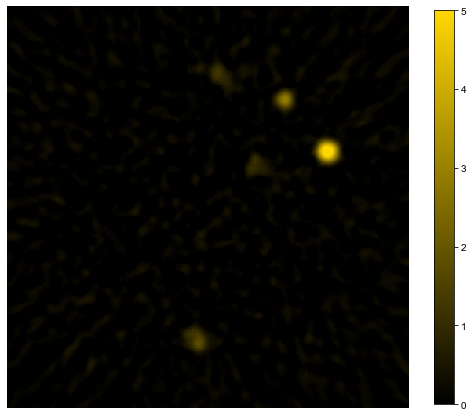

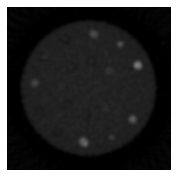

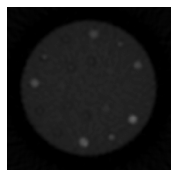

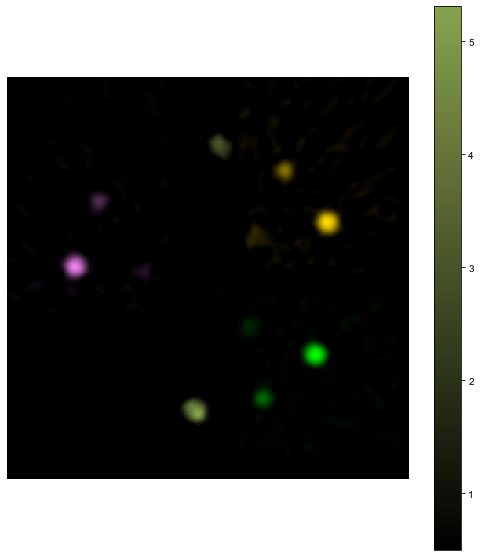

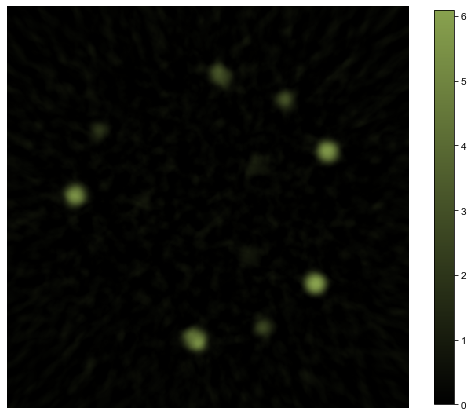

In [2]:
import tigre
import numpy as np
import tigre.algorithms as algs
from matplotlib import pyplot as plt
from numpy import genfromtxt
from matplotlib.pyplot import figure
from skimage.transform import iradon
from matplotlib.colors import LinearSegmentedColormap



bin_width=5
bins=np.arange(20,110,bin_width)
master_counts=np.load("Desktop/CT imaging/master_counts_strip_8deg.npy")
master_counts=np.squeeze(master_counts)
master_binned=np.zeros((45,96,int(np.ceil(len(bins)))))
for k in np.arange(0,len(bins)):
    for i in np.arange(0,45):
        for j in np.arange(0,96):
            master_binned[i][j][k]=master_counts[i][j][int(np.around((bins[0]+bin_width*k)/0.2)):int(np.around((((bins[0]+bin_width*(k+1))/0.2))))].mean()
master_binned=np.transpose(master_binned)
master_counts=master_binned
master_counts=np.swapaxes(master_counts,1,2)
for i in np.arange(0,len(master_counts)):
    master_counts[i][4]=np.insert(master_counts[i][4][:-1],0,0)
    master_counts[i][38]=np.insert(master_counts[i][38][:-1],0,0)
master_counts=np.swapaxes(master_counts,1,2)

print(bins[12],bins[11])
subtraction=master_counts[12]-master_counts[11]
subtraction = np.copy((subtraction.T)[:,np.newaxis,:]).astype(np.float32)

#Colormaps
cmap = LinearSegmentedColormap.from_list(name='lime',colors=['black','lime'])
plt.register_cmap('lime', cmap)
cmap = LinearSegmentedColormap.from_list(name='violet',colors=['black','violet'])
plt.register_cmap('violet', cmap)
cmap = LinearSegmentedColormap.from_list(name='gold',colors=['black','gold'])
plt.register_cmap('gold', cmap)
cmap = LinearSegmentedColormap.from_list(name='brown',colors=['black','#88a14e'])
plt.register_cmap('brown', cmap)

#Algorithms------------------------------------------------------------------------
niter=20

#FDK
c=imgFDKAu = algs.fdk(subtraction, geo, angles, filter='hann')
imgFDKAu=np.squeeze(imgFDKAu)
imgFDKAu[imgFDKAu<0] = 0
# CGLS
imgCGLS = algs.cgls(subtraction, geo, angles, niter)
imgCGLS=np.squeeze(imgCGLS)
imgCGLS[imgCGLS<0] = 0
# SART
imgSART = algs.sart(subtraction, geo, angles, niter)
imgSART=np.squeeze(imgSART)
imgSART[imgSART<0] = 0

#SIRT
imgSIRT= algs.sirt(subtraction,geo,angles,niter)
imgSIRT=np.squeeze(imgSIRT)
imgSIRT[imgSIRT<0] = 0

# # FISTA
# imgFISTA = algs.fista(subtraction, geo, angles, niter)
# imgFISTA=np.squeeze(imgFISTA)
# imgFISTA[imgFISTA<0] = 0

# # ASDPOCS
# imgASDPOCS = algs.asd_pocs(subtraction, geo, angles, niter)
# imgASDPOCS=np.squeeze(imgASDPOCS)
# imgASDPOCS[imgASDPOCS<0] = 0

# # AWASDPOCS
# imgAWASDPOCS = algs.awasd_pocs(subtraction, geo, angles, niter)
# imgAWASDPOCS=np.squeeze(imgAWASDPOCS)
# imgAWASDPOCS[imgAWASDPOCS<0] = 0

#Normalize and rotate
imgFDKAu=imgFDKAu*5/0.04796637799590826*5/5.046171681880951
imgFDKAu=imgFDKAu.T
#Display -------------------------------------------------------------------------------------------
figure(1,figsize=(9,10))
plt.imshow(imgFDKAu,cmap='gold',vmax=5)
plt.colorbar(shrink=0.725)
plt.axis('off')

# figure(2,figsize=(9,8))
# plt.imshow(imgCGLS,cmap='gold')
# plt.colorbar()
# plt.title('CGLS Image')

# figure(3,figsize=(9,8))
# plt.imshow(imgSART,cmap='gold')
# plt.colorbar()
# plt.title('SART Image')
# figure(4,figsize=(9,8))
# plt.imshow(imgSIRT,cmap='gold')
# plt.colorbar()
# plt.title('SIRT Image')

# figure(5,figsize=(9,8))
# plt.imshow(imgFISTA,cmap='gold')
# plt.colorbar()
# plt.title('FISTA Image')

# figure(6,figsize=(9,8))
# plt.imshow(imgASDPOCS,cmap='gold')
# plt.colorbar()
# plt.title('ASD_POCS Image')

# figure(7,figsize=(9,8))
# plt.imshow(imgAWASDPOCS,cmap='gold')
# plt.colorbar()
# plt.title('AWASD_POCS Image')

images=[]
for i in np.arange(0,len(bins)):
    img=algs.fdk(np.copy((np.array(master_counts[i]).T)[:,np.newaxis,:]).astype(np.float32), geo, angles, filter='hann')
    img=img.T
    img[img<0]=0
    images.append(img)
images=np.squeeze(images)


figure(90,figsize=(3,3))
plt.imshow(images[12],cmap='gray',vmin=0,vmax=0.25)
plt.axis('off')
figure(91,figsize=(3,3))
plt.imshow(images[11],cmap='gray',vmin=0,vmax=0.25)
plt.axis('off')

Auarea=[[i+295,j+0] for i in np.arange(0,200) for j in np.arange(0,250)]
Gdarea=[[i+295,j+280] for i in np.arange(0,200) for j in np.arange(0,200)]
Iarea=[[i+0,j+0] for i in np.arange(0,205) for j in np.arange(0,300)]
Mixarea=[[i+210,j+0] for i in np.arange(0,90) for j in np.arange(0,512)]

mask=np.zeros(shape=(512,512))
for x,y in Auarea:
    mask[int(y)][int(x)]=1
Auarea=mask*imgFDKAu

mask=np.zeros(shape=(512,512))
for x,y in Gdarea:
    mask[int(y)][int(x)]=1
Gdarea=mask*imgFDKGd

mask=np.zeros(shape=(512,512))
for x,y in Iarea:
    mask[int(y)][int(x)]=1
Iarea=mask*imgFDKI

mask=np.zeros(shape=(512,512))
tot_image=imgFDKI+imgFDKGd+imgFDKAu
for x,y in Mixarea:
    mask[int(y)][int(x)]=1
Mixarea=mask*tot_image

Auarea = np.ma.masked_where(Auarea <0.0005*100, Auarea)
Iarea = np.ma.masked_where(Iarea <0.0005*100, Iarea)
Gdarea = np.ma.masked_where(Gdarea <0.0005*100, Gdarea)
Mixarea=np.ma.masked_where(Mixarea <0.005*100, Mixarea)

figure(6,figsize=(9,10))
plt.imshow(np.zeros((512,512)),cmap='violet')
plt.imshow(Auarea,cmap='gold')
plt.imshow(Gdarea,cmap='lime')
plt.imshow(Iarea,cmap='violet')
plt.imshow(Mixarea,cmap='brown')
plt.colorbar()
plt.axis('off')

figure(7,figsize=(9,10))
plt.imshow(tot_image,cmap='brown')
plt.axis('off')
plt.colorbar(shrink=0.725)

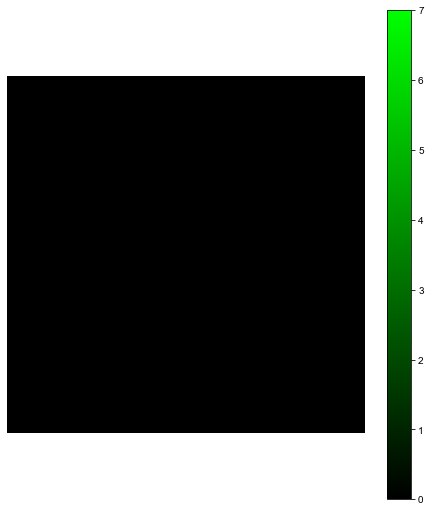

In [4]:
figure(8,figsize=(8,9))
plt.axis('off')
plt.imshow(np.zeros((512,512)),cmap='lime',vmin=0,vmax=7)
plt.colorbar()
# plt.imshow(imgFDKGd,cmap='lime',alpha=0.5)
# plt.imshow(imgFDKAu,cmap='gold',alpha=0.4)
# plt.imshow(imgFDKI,cmap='violet',alpha=0.4)

In [5]:
#Noise

mask=np.zeros(shape=(512,512))
for x,y in coords01:
    mask[int(y)][int(x)]=1
vial7=mask*imgFDKI
if (vial7==0).all()==False:
    vial7[vial7==0]=np.nan
    vial7_mean=np.nanmean(vial7)
    vial7_std=np.nanstd(vial7)
else:
    vial7_mean=0
    vial7_std=0

mask=np.zeros(shape=(512,512))
for x,y in coords02:
    mask[int(y)][int(x)]=1
vial8=mask*imgFDKI
if (vial8==0).all()==False:
    vial8[vial8==0]=np.nan
    vial8_mean=np.nanmean(vial8)
    vial8_std=np.nanstd(vial8)
else:
    vial8_mean=0
    vial8_std=0
    
mask=np.zeros(shape=(512,512))
for x,y in coords03:
    mask[int(y)][int(x)]=1
vial9=mask*imgFDKI
if (vial9==0).all()==False:
    vial9[vial9==0]=np.nan
    vial9_mean=np.nanmean(vial9)
    vial9_std=np.nanstd(vial9)
else:
    vial9_mean=0
    vial9_std=0
    
print(vial7_std,vial8_std,vial9_std)
print(np.std([vial7_std,vial8_std,vial9_std])/np.sqrt(3))
print((vial7_std+vial8_std+vial9_std)/3)

0.036699966856515415 0.055483097613022454 0.03141743802614028
0.005962435132690021
0.04120016749855938


5% I 0.9999999608993531
3% I 0.36668182754516604
1% I 0.14690310621261599
3.3% I 0.3110957242250442
2% I 0.19153924179077148
0% I 0.0
[0.92961754]
[0.8924212]


([<matplotlib.axis.YTick at 0x2af07120548>,
 <a list of 7 Text yticklabel objects>)

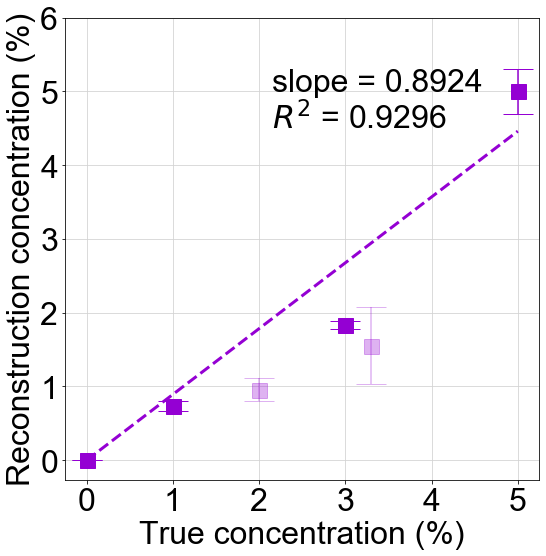

In [23]:
#Vial pixel intensity vs concentration
mask=np.zeros(shape=(512,512))
for x,y in coordsI5:
    mask[int(y)][int(x)]=1
vial1=mask*imgFDKI
vial1[vial1==0]=np.nan
vial1_mean=np.nanmean(vial1)
vial1_std=np.nanstd(vial1)
print('5% I', vial1_mean/5)

mask=np.zeros(shape=(512,512))
for x,y in coordsI3:
    mask[int(y)][int(x)]=1
vial2=mask*imgFDKI
vial2[vial2==0]=np.nan
vial2_mean=np.nanmean(vial2)
vial2_std=np.nanstd(vial2)
print('3% I', vial2_mean/5)

mask=np.zeros(shape=(512,512))
for x,y in coordsI1:
    mask[int(y)][int(x)]=1
vial3=mask*imgFDKI
vial3[vial3==0]=np.nan
vial3_mean=np.nanmean(vial3)
vial3_std=np.nanstd(vial3)
print('1% I', vial3_mean/5)


mask=np.zeros(shape=(512,512))
for x,y in coordsMix33:
    mask[int(y)][int(x)]=1
vial4=mask*imgFDKI
vial4[vial4==0]=np.nan
vial4_mean=np.nanmean(vial4)
vial4_std=np.nanstd(vial4)
print('3.3% I', vial4_mean/5)

mask=np.zeros(shape=(512,512))
for x,y in coordsMix2:
    mask[int(y)][int(x)]=1
vial5=mask*imgFDKI
vial5[vial5==0]=np.nan
vial5_mean=np.nanmean(vial5)
vial5_std=np.nanstd(vial5)
print('2% I', vial5_mean/5)

mask=np.zeros(shape=(512,512))
for x,y in coords0:
    mask[int(y)][int(x)]=1
vial6=mask*imgFDKI
if (vial6==0).all()==False:
    vial6[vial6==0]=np.nan
    vial6_mean=np.nanmean(vial6)
    vial6_std=np.nanstd(vial6)
else:
    vial6_mean=0
    vial6_std=0
print('0% I', vial6_mean/5)

vial_means1=np.array([vial6_mean,vial3_mean,vial2_mean,vial1_mean])
conc1=np.array([0,1,3,5])
error1=[vial6_std,vial3_std,vial2_std,vial1_std]
vial_means2=[vial5_mean,vial4_mean]
conc2=np.array([2,3.3])
error2=[vial5_std,vial4_std]
conc1=np.array([0,1,3,5])
vial_means_lin=[vial6_mean,vial3_mean,vial2_mean,vial1_mean]

m = np.linalg.lstsq(conc1[:,np.newaxis], vial_means1,rcond=-1)[0]
resid = np.linalg.lstsq(conc1[:,np.newaxis], vial_means1,rcond=-1)[1]
r2 = 1 - resid / (vial_means1.size * vial_means1.var())
print(r2)
print(m)
figure(9,figsize=(8.5,8.5))
plt.errorbar(conc1,vial_means1,marker='s',yerr=error1,capsize=15,markersize=15,linestyle='',c='darkviolet')
plt.errorbar(conc2,vial_means2,marker='s',yerr=error2,capsize=15,markersize=15,linestyle='',c='darkviolet',alpha=0.3)
plt.plot(conc1,conc1*m,c='darkviolet',linestyle='--',lw=3)
plt.xlabel('True concentration (%)')
plt.ylabel('Reconstruction concentration (%)')
plt.annotate("$R^2$ = {:.4f}".format(r2[0]), (2.15, 4.5))
plt.annotate("slope = {:.4f}".format(m[0]), (2.15, 5))
plt.grid(c='lightgray')
plt.xticks([0,1,2,3,4,5])
plt.yticks([0,1,2,3,4,5,6])



0% I 0.03892374247312546


(-0.5, 511.5, 511.5, -0.5)

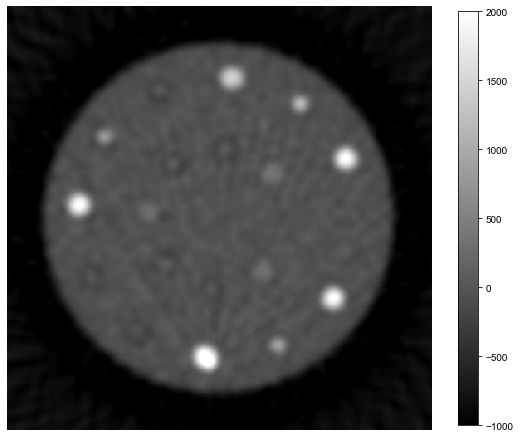

In [7]:
bin_width=98
bins=np.arange(23,121,bin_width)
master_counts=np.load("Desktop/CT imaging/master_counts_strip_8deg.npy")
master_counts=np.squeeze(master_counts)
master_binned=np.zeros((45,96,int(np.ceil(len(bins)))))
for k in np.arange(0,len(bins)):
    for i in np.arange(0,45):
        for j in np.arange(0,96):
            master_binned[i][j][k]=master_counts[i][j][int(np.around((bins[0]+bin_width*k)/0.2)):int(np.around((((bins[0]+bin_width*(k+1))/0.2))))].mean()
master_binned=np.transpose(master_binned)
master_counts=master_binned
master_counts=np.swapaxes(master_counts,1,2)
for i in np.arange(0,len(master_counts)):
    master_counts[i][4]=np.insert(master_counts[i][4][:-1],0,0)
    master_counts[i][38]=np.insert(master_counts[i][38][:-1],0,0)
master_counts=np.swapaxes(master_counts,1,2)
x=master_counts[0]
x= np.copy((x.T)[:,np.newaxis,:]).astype(np.float32)

CTimg = algs.fdk(x, geo, angles, filter='hann')
CTimg=np.squeeze(CTimg)
CTimg[CTimg<0] = 0

mask=np.zeros(shape=(512,512))
for x,y in coords0:
    mask[int(y)][int(x)]=1
vial6=mask*CTimg
if (vial6==0).all()==False:
    vial6[vial6==0]=np.nan
    vial6_mean=np.nanmean(vial6)
    vial6_std=np.nanstd(vial6)
else:
    vial6_mean=0
    vial6_std=0
print('0% I', vial6_mean)

mu_water=0.03892374247312546
figure(27,figsize=(9.5,10.5))
plt.imshow((CTimg.T/mu_water)*1000-1000,cmap='gray',vmax=2000)
plt.colorbar(shrink=0.725)
plt.axis('off')

